# Prof. Keller's new proposed method

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from BHDVCStf import BHDVCS #modified bhdvcs file
bhdvcs = BHDVCS()

In [154]:
class DvcsData(object):
    def __init__(self, df):
        self.df = df
        self.X = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'ReH', 'ReE', 'ReHtilde', 'dvcs']]
        self.XnoCFF = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]
        self.y = df.loc[:, 'F']
        self.Kinematics = df.loc[:, ['k', 'QQ', 'x_b', 't']]
        self.erry = df.loc[:, 'errF']
        
    def __len__(self):
        return len(self.X)
    
    def getSet(self, setNum, itemsInSet=36):
        pd.options.mode.chained_assignment = None
        subX = self.X.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1, :]
        subX['F'] = self.y.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        subX['errF'] = self.erry.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        pd.options.mode.chained_assignment = 'warn'
        return DvcsData(subX)
    
    def sampleY(self):
        return np.random.normal(self.y, self.erry)
    
    def sampleWeights(self):
        return 1/self.erry
    
    def getAllKins(self, itemsInSets=36):
        return self.Kinematics.iloc[np.array(range(len(df)//itemsInSets))*itemsInSets, :]

In [155]:
df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = DvcsData(df)

In [6]:
class TotalUUXS(tf.keras.layers.Layer):
    def __init__(self):
        super(TotalUUXS, self).__init__(dtype='float64')
        self.F = BHDVCS()
    def call(self, inputs):
        return self.F.TotalUUXS(inputs[:, :8], inputs[:, 8], inputs[:, 9], inputs[:, 10])

In [7]:
numReplicas = 100
numSets = 15

In [8]:
replicas = np.fromfile('GlobalFit2Replicas.txt')
replicas = replicas.reshape(numSets, numReplicas, 3)

In [21]:
class f1_f2(object):
    def __init__(self):
        # this could be refactored to include the constants that are written explicitly below
        pass
    
    @staticmethod
    def ffGE(t):
        GE = 1.0 / ( 1.0 + ( -t / 0.710649 ) ) / ( 1.0 + ( -t / 0.710649 ) )
        return GE

    @staticmethod
    def ffGM(t):
        shape = f1_f2.ffGE(t)
        GM0 = 2.792847337
        return GM0*shape
    
    @staticmethod
    def ffF2(t):
        f2 = (f1_f2.ffGM(t) - f1_f2.ffGE(t)) / (1. - t / (4.*.938272*.938272));
        return f2
    
    @staticmethod
    def ffF1(t):
        f1 = f1_f2.ffGM(t) - f1_f2.ffF2(t)
        return f1
    
    @staticmethod
    def ffGA(t):
        ga = 1.2695
        ma = 1.026
        part = t/(ma*ma);
        dif = (1-part)*(1-part);
        GA = ga/dif
        return GA

In [361]:
class step3sim(object):
    def __init__(self, X, replicas, whichSet, numSamples=10000):
        # sample range of 10,000, with replicas repeated and appended to fill
        
        self.X = X
        self.cffs = replicas[whichSet, :, :]
        self.whichSet = whichSet
        if int(numSamples**.25)**4 != numSamples:
            numSamples = int(numSamples**.25)**4
            print('numSamples must be perfect power of 4, using ' + str(numSamples) + ' instead!')
        
        self.numSamples = numSamples
        
        self.kins = X.loc[whichSet*36, ['k', 'QQ', 'x_b', 't']]
        self.dvcs = X.loc[whichSet*36, 'dvcs']
            
    
    def _getKinRange(self, whichKin):
        
        krange = np.unique(self.X[whichKin].sort_values())
        idx = np.where(krange == self.kins[whichKin])[0][0]
        num = int(self.numSamples**.25)
        
        #return krange, idx, num
        if idx == 0:
            to_ret = np.linspace(self.kins[whichKin]*2 - krange[idx + 1], krange[idx + 1], num=num)
        elif idx == (len(krange) - 1):
            to_ret = np.linspace(krange[idx - 1], 2*self.kins[whichKin] - krange[idx - 1], num=num)
        else:
            to_ret = np.linspace(krange[idx - 1], krange[idx + 1], num=num)
        return to_ret

    
    def addFs(self, sd):
        bhdvcs = BHDVCS()
        sd['F'] = bhdvcs.TotalUUXS(np.array(sd[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]),
                                  np.array(sd['ReH']), np.array(sd['ReE']), np.array(sd['ReHtilde']))
        return sd    

    
    def getSimData(self):
        kins = [self._getKinRange(kin) for kin in ['k', 'QQ', 'x_b', 't']]
        kins = np.array(np.meshgrid(*kins)).T.reshape(-1,4)
        to_ret = {key: [] for key in self.X.columns}
        to_ret['k'] = kins[:, 0]
        to_ret['QQ'] = kins[:, 1]
        to_ret['x_b'] = kins[:, 2]
        to_ret['t'] = kins[:, 3]
        
        to_ret['F1'] = f1_f2.ffF1(to_ret['t'])
        to_ret['F2'] = f1_f2.ffF1(to_ret['t'])
        
        cffs = np.repeat(self.cffs, 100, axis=0) #needs to be changed to accomodate numSamples
        np.random.shuffle(cffs)
        
        to_ret['ReH'] = cffs[:, 0]
        to_ret['ReE'] = cffs[:, 1]
        to_ret['ReHtilde'] = cffs[:, 2]
        
        to_ret['dvcs'] = np.repeat(self.dvcs, self.numSamples)
        
        phis = np.repeat(np.linspace(0, 350, 36), self.numSamples//36 + 1)
        to_ret['phi_x'] = phis[:self.numSamples]
        
        sd = pd.DataFrame(to_ret)
        sd = self.addFs(sd)
        return sd
    

In [362]:
def fit_pred_kinSet(whichSet, data, replicas):
    
    s3 = step3sim(data.X, replicas, whichSet)
    locData = s3.getSimData()
    
    locData = locData.dropna()
    print(len(locData))
    
    rescaler = MinMaxScaler()
    rescaler = rescaler.fit(locData[['k', 'QQ', 'x_b', 't', 'F']])
    X = rescaler.transform(locData[['k', 'QQ', 'x_b', 't', 'F']])
    y = locData[['ReH', 'ReE', 'ReHtilde']]
    
    
    model = tf.keras.models.Sequential([
    #tf.keras.layers.Dropout(input_shape=(5,), rate=0.2),
    tf.keras.layers.Dense(20, input_shape=(5,), activation="elu", kernel_initializer="he_normal"),
    #tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(20, activation="elu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3)
    ])
    
    model.compile(
    optimizer = tf.keras.optimizers.Nadam(.01),
    loss = tf.keras.losses.MeanSquaredError()
    )
    
    model.fit(X, y, epochs=100, verbose=0)
        
    fs = np.concatenate([data.getSet(whichSet).sampleY() for _ in range(100)])

    to_pred = np.tile(np.array(data.df.loc[whichSet*36 + 18, ['k', 'QQ', 'x_b', 't']]), (3600, 1))

    to_pred = pd.DataFrame(to_pred)

    to_pred[4] = fs

    to_pred = rescaler.transform(to_pred)
    
    yhat = np.stack([model(to_pred, training=True) for sample in range(100)])
    
    return yhat

In [363]:
def evaluate(y_yhat):
    '''
    Provides a few model evaluation statistics from an array of true values and predictions.
    
    :param y_yhat: numpy array with first column being true values and second being predicted values.
    '''
    pct_errs = ((y_yhat[:, 0] - y_yhat[:, 1])/y_yhat[:, 1])*100
    print('Mean percent error: ', np.mean(np.abs(pct_errs)))

    RS = np.square((y_yhat[:, 0] - y_yhat[:, 1]))
    TS = np.square((y_yhat[:, 0] - y_yhat[:, 0].mean()))
    rmse = np.sqrt(np.mean(RS))
    rmtss = np.sqrt(np.mean(TS))
    print('RMSE: ', rmse)
    print('RMSE w yhat=mean: ', rmtss)
    RSS = np.sum(RS)
    TSS = np.sum(TS)
    print('R-squared: ', (1 - RSS/TSS))
    plt.hist(np.array(pct_errs))
    plt.title('Histogram of Percent Errors')
    plt.show()

In [364]:
ReHy_yhat = []
ReEy_yhat = []
ReHtildey_yhat = []

for whichSet in range(15):
    yhats = fit_pred_kinSet(whichSet, data, replicas)
    ReHy_yhat.append([data.getSet(whichSet).X.iloc[0, 7], yhats[:, :, 0].mean()])
    ReEy_yhat.append([data.getSet(whichSet).X.iloc[0, 8], yhats[:, :, 1].mean()])
    ReHtildey_yhat.append([data.getSet(whichSet).X.iloc[0, 9], yhats[:, :, 2].mean()])

10000
9300
9840
10000
10000
10000
9790
10000
10000
10000
10000
10000
10000
10000
10000


Mean percent error:  26.081011729409965
RMSE:  1.7918917339039633
RMSE w yhat=mean:  2.5254628436780107
R-squared:  0.4965671327830059


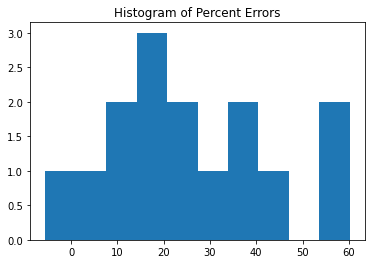

In [365]:
evaluate(np.array(ReHy_yhat))

Mean percent error:  23.8733414529087
RMSE:  9.822996381820317
RMSE w yhat=mean:  2.525480507907797
R-squared:  -14.128641316531661


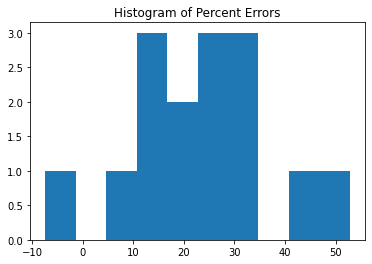

In [366]:
evaluate(np.array(ReEy_yhat))

Mean percent error:  16.93143165464034
RMSE:  0.7225231871338786
RMSE w yhat=mean:  1.4030345621243816
R-squared:  0.7348040795492108


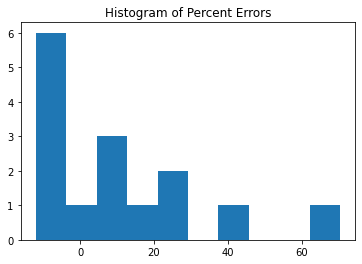

In [367]:
evaluate(np.array(ReHtildey_yhat))

# Evaluate Replicas

In [374]:
ReHy_yhat = []
ReEy_yhat = []
ReHtildey_yhat = []

for whichSet in range(15):
    ReHy_yhat.append([data.getSet(whichSet).X.iloc[0, 7], replicas[whichSet, :, 0].mean()])
    ReEy_yhat.append([data.getSet(whichSet).X.iloc[0, 8], replicas[whichSet, :, 1].mean()])
    ReHtildey_yhat.append([data.getSet(whichSet).X.iloc[0, 9], replicas[whichSet, :, 2].mean()])

Mean percent error:  10.432250414644347
RMSE:  1.016593117128301
RMSE w yhat=mean:  2.5254628436780107
R-squared:  0.8379636829673103


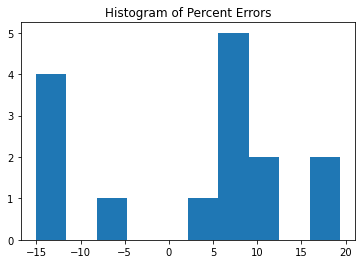

In [375]:
evaluate(np.array(ReHy_yhat))

Mean percent error:  11.057921264644353
RMSE:  5.675738319631367
RMSE w yhat=mean:  2.525480507907797
R-squared:  -4.050759464517492


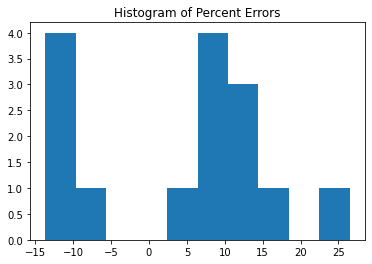

In [376]:
evaluate(np.array(ReEy_yhat))

Mean percent error:  7.992647189510513
RMSE:  0.42766634278934085
RMSE w yhat=mean:  1.4030345621243816
R-squared:  0.9070876581634342


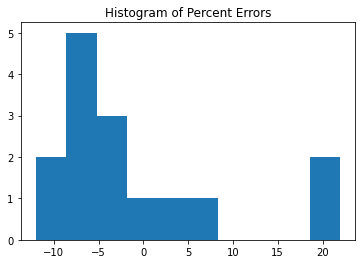

In [377]:
evaluate(np.array(ReHtildey_yhat))